# CF

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType

spark = SparkSession \
    .builder \
    .appName("Spark_Processor") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext

schema = StructType([ \
        StructField("DEVICE_CODE", IntegerType(), True), 
        StructField("SYSTEM_ID",IntegerType(),True), \
        StructField("ORIGINE_CAR_KEY",IntegerType(),True), \
        StructField("FINAL_CAR_KEY", IntegerType(),True), \
        StructField("CHECK_STATUS_KEY", IntegerType(), True), \
        StructField("COMPANY_ID", StringType(), True), \
        StructField("PASS_DAY_TIME", TimestampType(), True)
    ])

22/02/08 17:46:12 WARN Utils: Your hostname, jupyter resolves to a loopback address: 127.0.1.1; using 172.16.199.17 instead (on interface eth0)
22/02/08 17:46:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/08 17:46:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/02/08 17:46:16 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
df = spark.read.csv('Traffic.csv',header=True,schema=schema)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



In [3]:
from pyspark.sql.functions import dayofyear
df = df.withColumn('day', dayofyear(df.PASS_DAY_TIME))
df = df.filter(df.day != 159)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|152|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
only showing top 1 row



In [4]:
from pyspark.sql.functions import hour,dayofweek, count
from pyspark.sql.window import Window

window = Window.partitionBy('FINAL_CAR_KEY')
df_with_car_count = df.withColumn('count', count('FINAL_CAR_KEY').over(window))
df_cleaned = df_with_car_count.filter(df_with_car_count['count'] < 1000)
df_cleaned.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+-----+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|count|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+-----+
|        114|       81|        7631984|      7631984|               5|       161|2021-06-03 07:34:29|154|   15|
|     631781|       81|        7631984|      7631984|               5|       161|2021-06-03 07:32:39|154|   15|
|     900130|      283|        7631984|      7631984|               5|       264|2021-06-03 13:04:24|154|   15|
|     203001|       81|        7631984|      7631984|               5|       161|2021-06-03 13:13:56|154|   15|
|     631349|       81|        7631984|      7631984|               5|       161|2021-06-03 13:26:40|154|   15|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---

In [5]:
camera_time_count = df_cleaned.withColumn('time', (dayofweek(df.PASS_DAY_TIME)-1)*24 + hour(df.PASS_DAY_TIME))
camera_time_count = camera_time_count.groupBy('DEVICE_CODE', 'time').count()
camera_time_count.show(5)

+-----------+----+-----+
|DEVICE_CODE|time|count|
+-----------+----+-----+
|     900265|  35| 1608|
|     631361|  89|  910|
|     900216|  55| 1758|
|  100700901|  62|   54|
|  100700845|   6|  886|
+-----------+----+-----+
only showing top 5 rows



In [6]:
from pyspark.ml.recommendation import ALS

training, test = camera_time_count.randomSplit([0.8, 0.2])

als = ALS(
    maxIter = 5, 
    regParam = 0.01, 
    userCol = 'DEVICE_CODE', 
    itemCol = 'time', 
    ratingCol = 'count',
    coldStartStrategy= 'drop')

model = als.fit(training)

22/02/08 17:53:26 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/02/08 17:53:26 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/02/08 17:53:26 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [7]:
from pyspark.ml.evaluation import RegressionEvaluator
predictions = model.transform(test)
print(type(predictions))
predictions.show(5)
evaluator = RegressionEvaluator(
    metricName = 'rmse', 
    labelCol = 'count',
    predictionCol = 'prediction'
    )
rmse = evaluator.evaluate(predictions)
print('Root-mean-square error = ' + str(rmse))

<class 'pyspark.sql.dataframe.DataFrame'>


+-----------+----+-----+----------+
|DEVICE_CODE|time|count|prediction|
+-----------+----+-----+----------+
|        100|  68|  802|  704.4001|
|        100|  80|  782| 829.27893|
|        100|  97|   78|  71.76814|
|        100| 159|  425| 341.87933|
|        101|  63|   35| 53.008274|
+-----------+----+-----+----------+
only showing top 5 rows



Root-mean-square error = 93.20994499805558


In [8]:
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(5)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(5)
movieRecs.show()

/home/user1/jupyter/environment/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+----+--------------------+
|time|     recommendations|
+----+--------------------+
|   0|[{900212, 1366.51...|
|   1|[{900212, 922.192...|
|   2|[{900212, 564.023...|
|   3|[{900212, 578.416...|
|   4|[{900212, 476.895...|
|   5|[{900212, 742.013...|
|   6|[{900212, 1804.88...|
|   7|[{900212, 2273.75...|
|   8|[{900212, 2670.10...|
|   9|[{900212, 3120.22...|
|  10|[{22010087, 4053....|
|  11|[{900212, 4541.64...|
|  12|[{22010088, 4861....|
|  13|[{900212, 4714.54...|
|  14|[{900212, 4234.07...|
|  15|[{900212, 3976.05...|
|  16|[{900212, 4427.97...|
|  17|[{900212, 5261.80...|
|  18|[{900212, 5554.40...|
|  19|[{22010088, 6046....|
+----+--------------------+
only showing top 20 rows



In [9]:
camera_subset = test.filter(df_cleaned.DEVICE_CODE < 105)
camera_subset.show(5)

+-----------+----+-----+
|DEVICE_CODE|time|count|
+-----------+----+-----+
|        100|  68|  802|
|        100|  80|  782|
|        100|  97|   78|
|        100| 159|  425|
|        101|  63|   35|
+-----------+----+-----+
only showing top 5 rows



In [10]:
prediction_subset = model.transform(camera_subset)
prediction_subset.show(5)

+-----------+----+-----+----------+
|DEVICE_CODE|time|count|prediction|
+-----------+----+-----+----------+
|        100|  68|  802|  704.4001|
|        100|  80|  782| 829.27893|
|        100|  97|   78|  71.76814|
|        100| 159|  425| 341.87933|
|        101|  63|   35| 53.008274|
+-----------+----+-----+----------+
only showing top 5 rows



In [11]:
def convert_to_vector(data_list):
    real = [0]*24*7
    predicted = [0]*24*7
    for time, count, prediction in data_list:
        real[time] = count
        predicted[time] = prediction

    return (real, predicted)

camera_predictions = prediction_subset.rdd.map(lambda x: (x.DEVICE_CODE, (
    x.time,
    x['count'],
    x['prediction']
))).groupByKey().mapValues(convert_to_vector).collect()

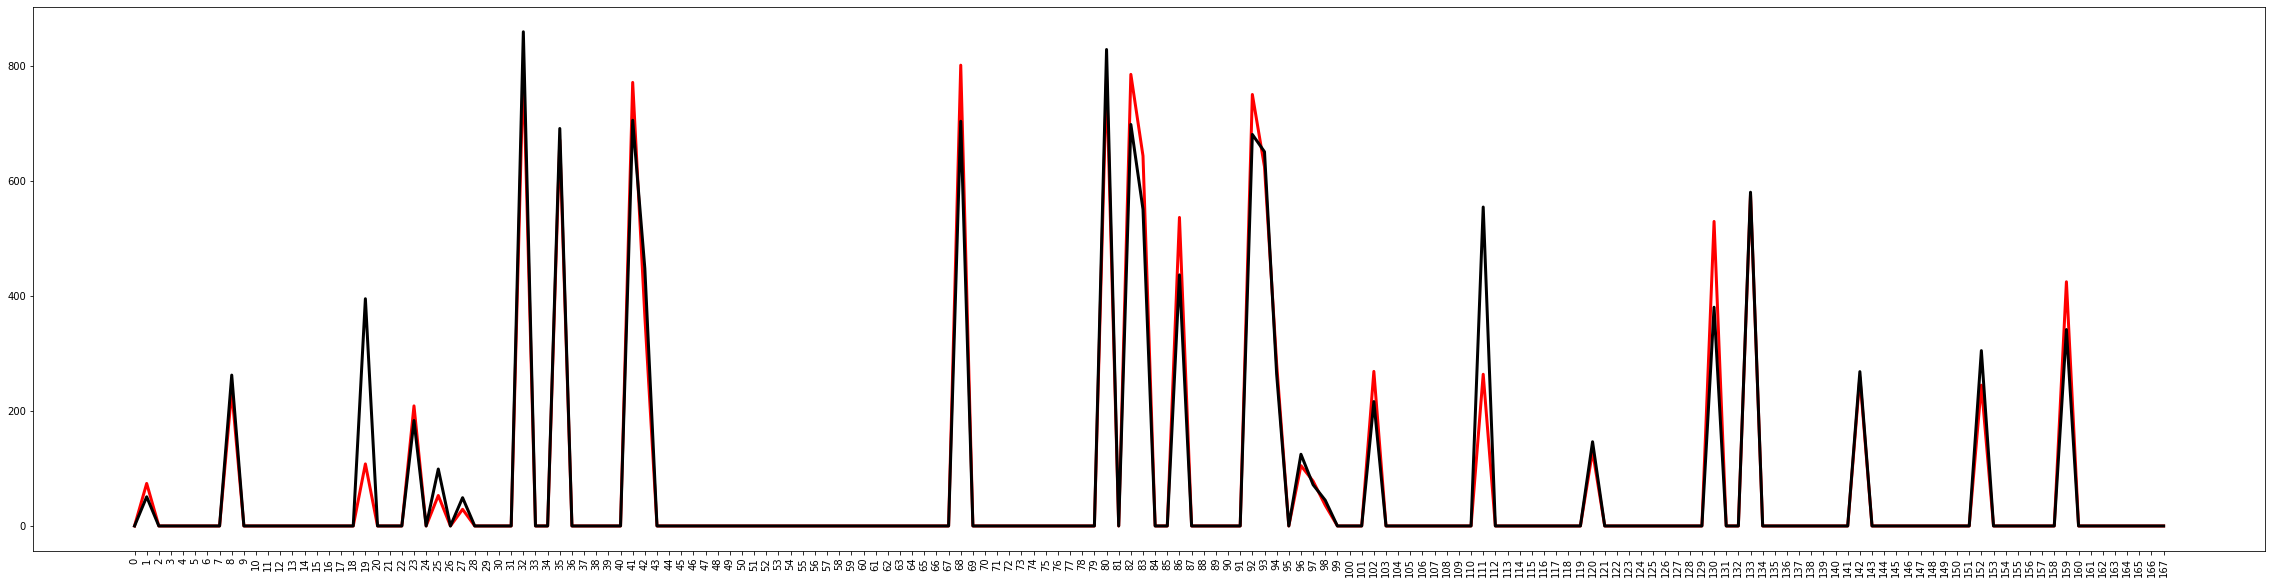

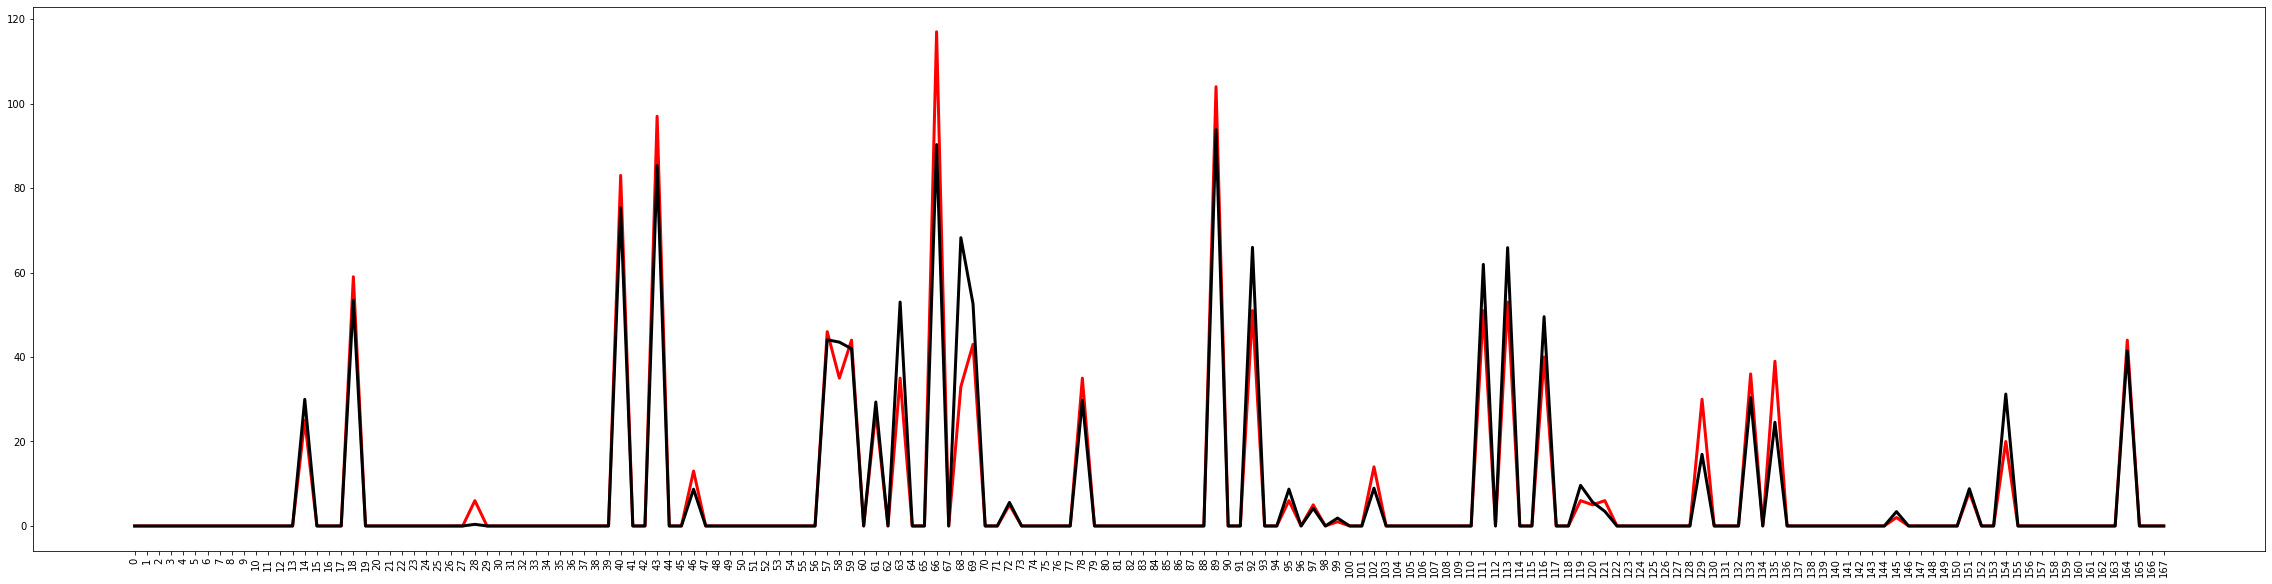

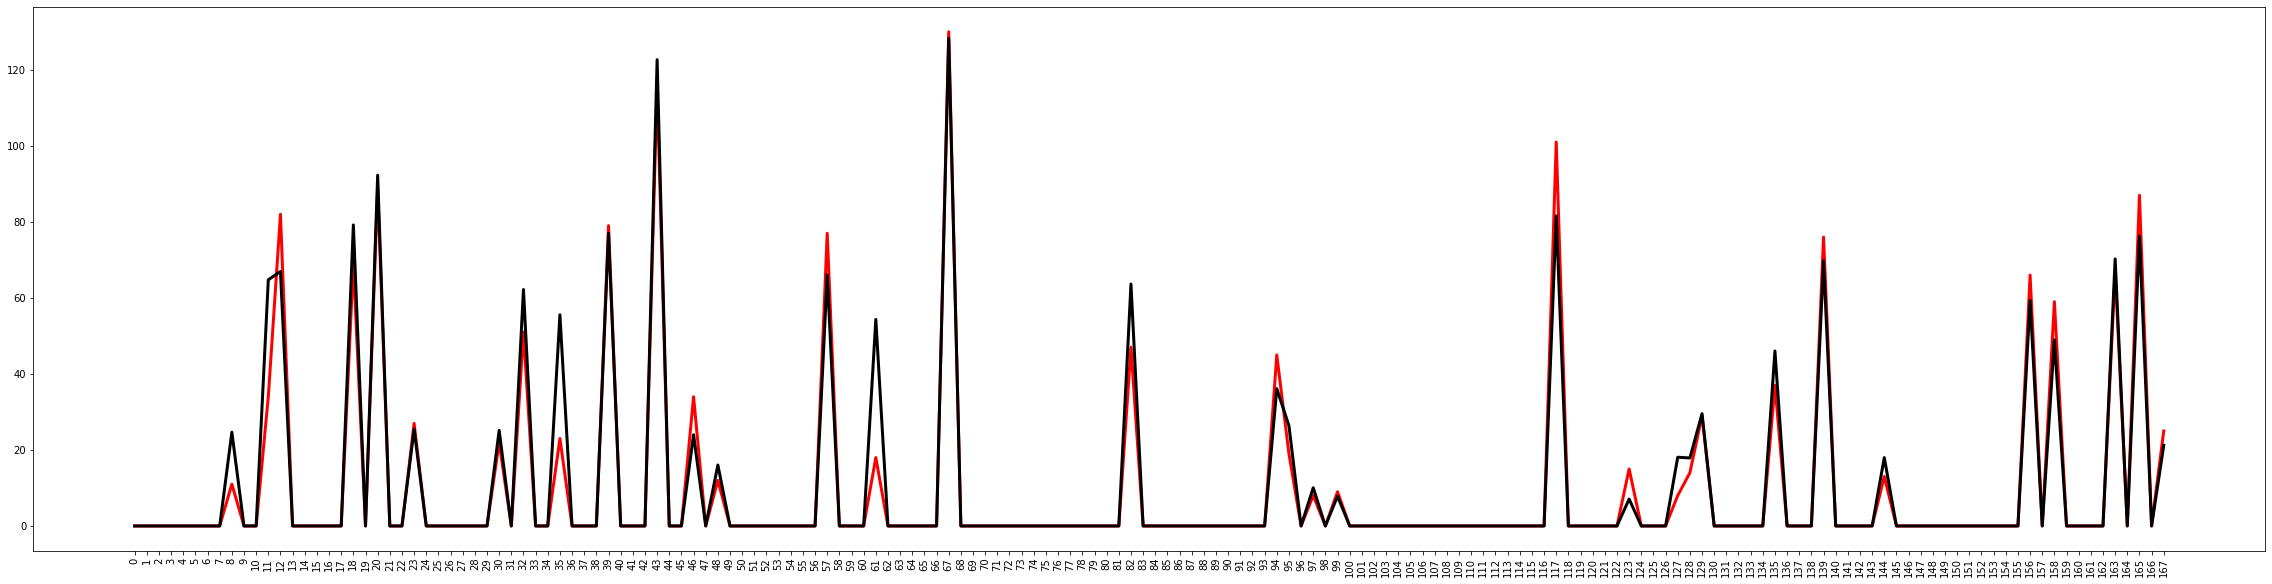

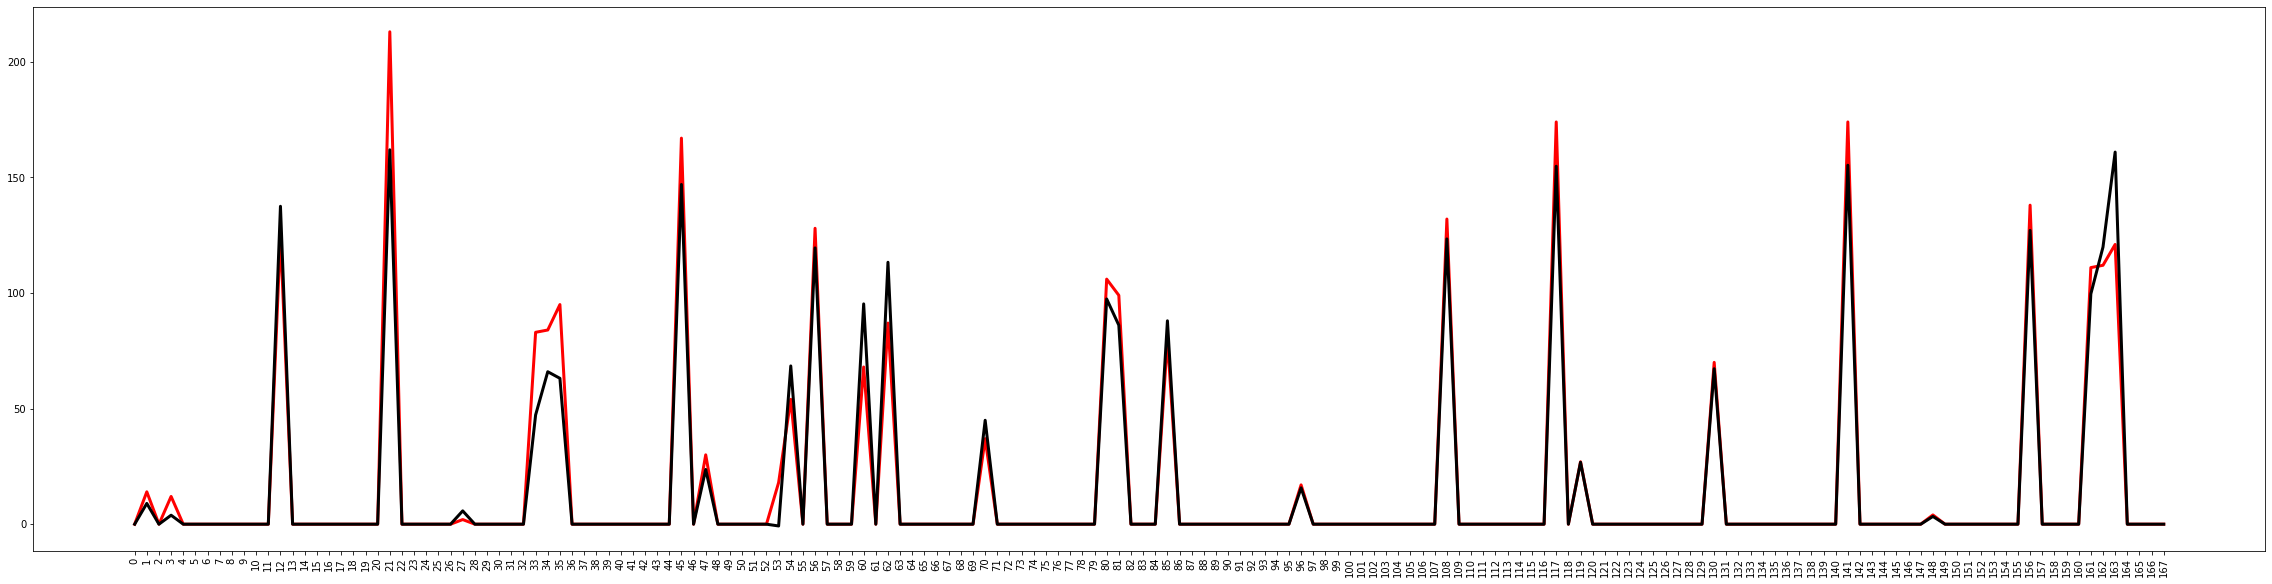

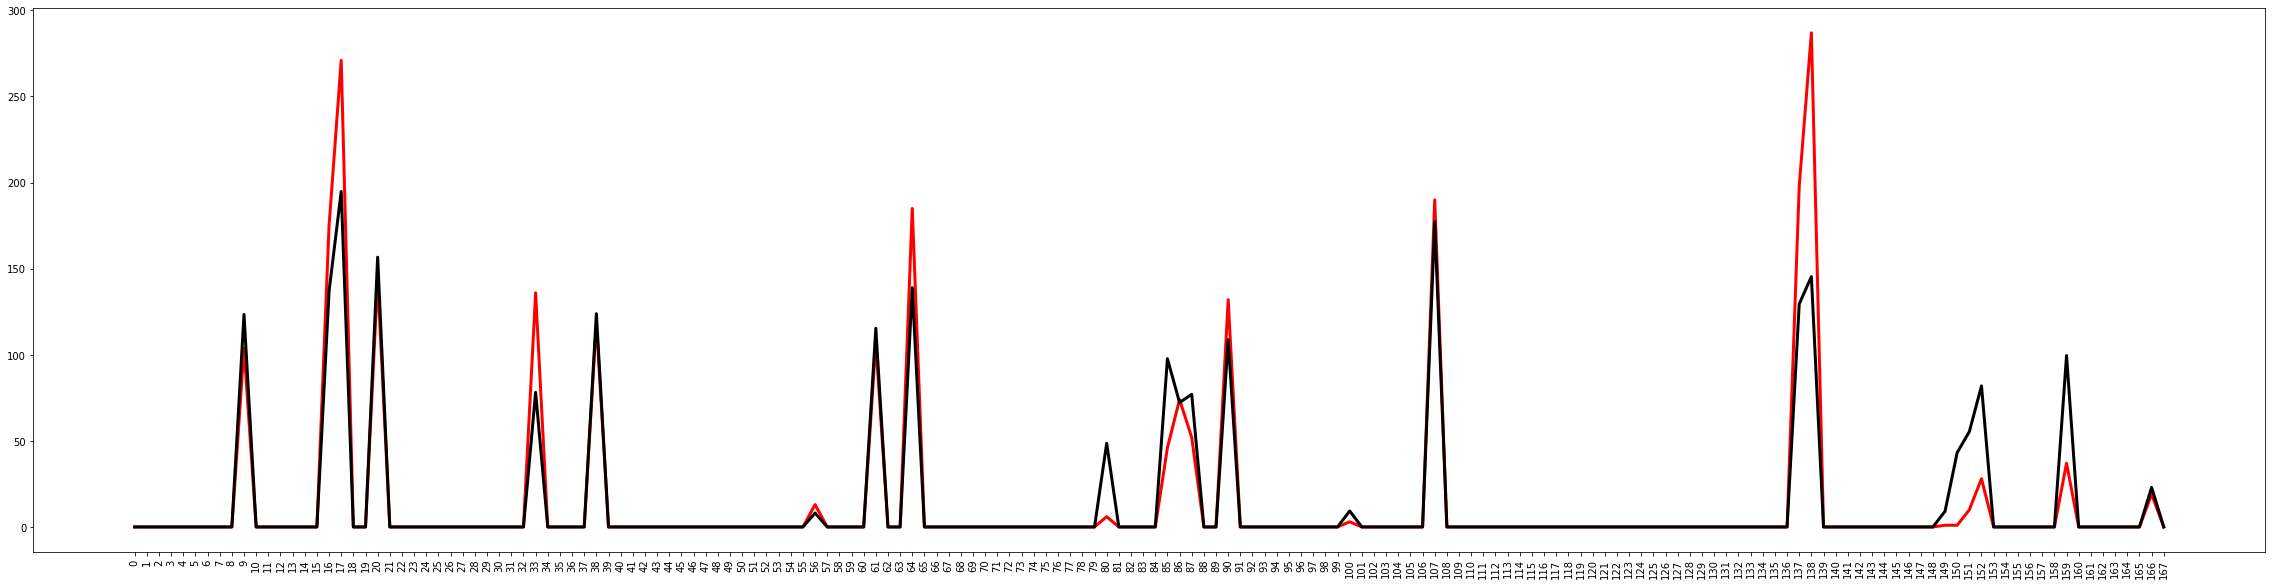

In [12]:
from matplotlib import pyplot as plt

for camera, (real_counts, predicted_counts) in camera_predictions:
    fig = plt.figure(figsize = (40, 10))
    labels = list(map(lambda x: str(x), range(24*7)))
    plt.plot(labels, real_counts, linewidth=3, color='red')
    plt.plot(labels, predicted_counts, linewidth=3, color='black')
    # plt.bar(labels, real_counts, color='red', width = 0.7, alpha=0.7)
    # plt.bar(labels, predicted_counts, color='black', width = 0.7, alpha=0.7)
    plt.xticks(rotation='vertical',fontsize=10)
    plt.show()
    # break